In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# Load the preprocessed data
train_data = np.load('../data/bias_train_data.npz')
val_data = np.load('../data/bias_val_data.npz')
test_data = np.load('../data/bias_test_data.npz')

X_train, y_train = train_data['frames'], train_data['labels']
X_val, y_val = val_data['frames'], val_data['labels']
X_test, y_test = test_data['frames'], test_data['labels']

In [5]:
# Flatten the images for logistic regression
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl =DeviceDataLoader(train_loader,device)
val_dl =DeviceDataLoader(val_loader,device)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
X_train[0].shape

torch.Size([100, 100])

In [12]:
input_size = 100*100
num_classes = len(np.unique(y_train))


In [13]:
class LogisticModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 10000)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
      return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # Set up cutom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
      # Training Phase
      model.train()
      train_losses = []
      lrs = []
      for batch in train_loader:
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward()

          # Gradient clipping
          if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()

      # Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      result['lrs'] = lrs
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [15]:
model = to_device(LogisticModel(), device)
model

LogisticModel(
  (linear): Linear(in_features=10000, out_features=4, bias=True)
)

## Training

In [16]:
torch.cuda.empty_cache()
for batch in train_dl:
  img, label = batch
  print(img.shape)
  print(img.device)
  preds = model(img)
  print(preds.shape)
  break

torch.Size([32, 100, 100])
cuda:0
torch.Size([32, 4])


In [17]:
for batch in val_dl:
  img, label = batch
  print(img.shape)
  print(img.device)
  preds = model(img)
  print(preds.shape)
  break

torch.Size([32, 100, 100])
cuda:0
torch.Size([32, 4])


In [18]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 23.857463836669922, 'val_acc': 0.5621052980422974}]

In [19]:
epochs = 8
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
import time
train_time = time.time()
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)
print(f"Training time: {time.time() - train_time:.3f} seconds")


Epoch [0], val_loss: 84.8222, val_acc: 0.5591
Epoch [1], val_loss: 730.3104, val_acc: 0.2079
Epoch [2], val_loss: 403.8366, val_acc: 0.1930
Epoch [3], val_loss: 213.3162, val_acc: 0.6832
Epoch [4], val_loss: 242.6351, val_acc: 0.4917
Epoch [5], val_loss: 51.0995, val_acc: 0.7276
Epoch [6], val_loss: 29.2799, val_acc: 0.8857
Epoch [7], val_loss: 24.4877, val_acc: 0.8945
Training time: 29.967 seconds


In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');



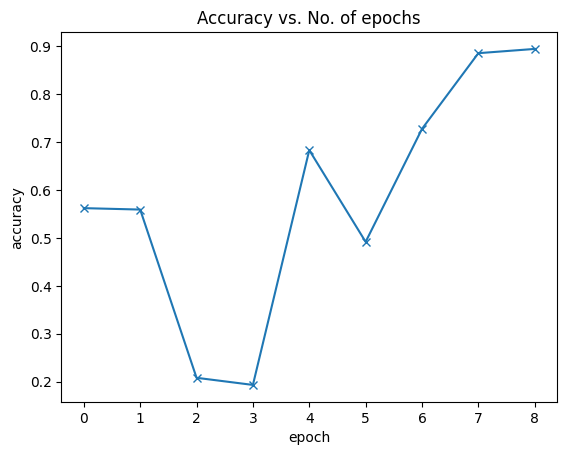

In [22]:
plot_accuracies(history)

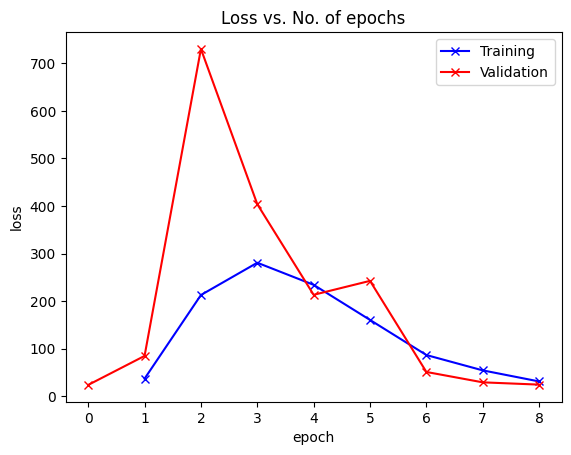

In [23]:
plot_losses(history)

## Testing

In [24]:
# Put the model in evaluation mode
model.eval()

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate through the test data and make predictions
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Convert outputs to probabilities using softmax
    probs = torch.softmax(outputs, dim=1)
    
    # Append true labels and predicted probabilities
    true_labels.extend(labels.cpu().numpy())
    predicted_probs.extend(probs.detach().cpu().numpy())

# Convert true labels to numpy array
true_labels = np.array(true_labels)

# Get predicted labels by selecting the class with the highest probability
predicted_labels = np.argmax(predicted_probs, axis=1)

In [25]:
import os

In [26]:


def plot_multiclass_classification_results(true_labels, predicted_labels, predicted_probs, class_names, save_dir=None):
    """
    Generate various plots for multiclass classification results.
    Args:
        true_labels (array-like): True labels.
        predicted_labels (array-like): Predicted labels.
        predicted_probs (array-like): Predicted probabilities.
        class_names (list): List of class names.
    """
    # Histogram of Class Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=true_labels, palette='Set2')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'class_distribution.png'))
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve((true_labels == i).astype(int), (predicted_labels == i).astype(int))
        plt.plot(recall, precision, marker='.', label=f'Class {class_names[i]}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'))
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve((true_labels == i).astype(int), (predicted_labels == i).astype(int) )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, marker='.', label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
    plt.show()


In [27]:
true_labels

array([0, 2, 0, ..., 3, 3, 3], dtype=int64)

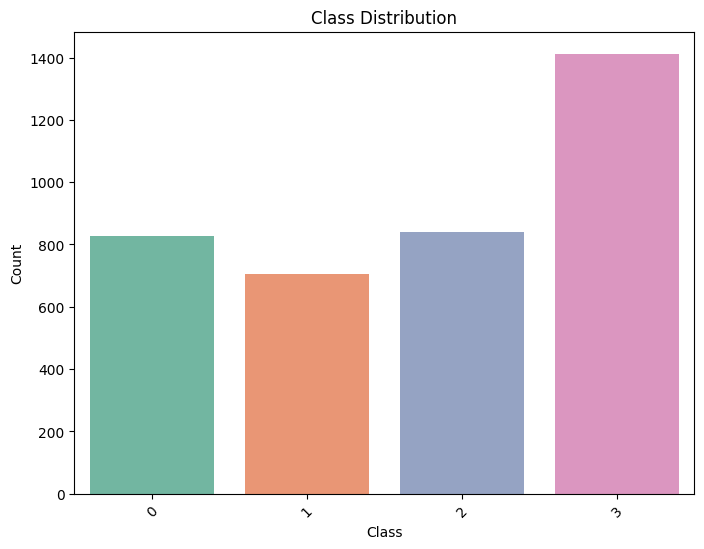

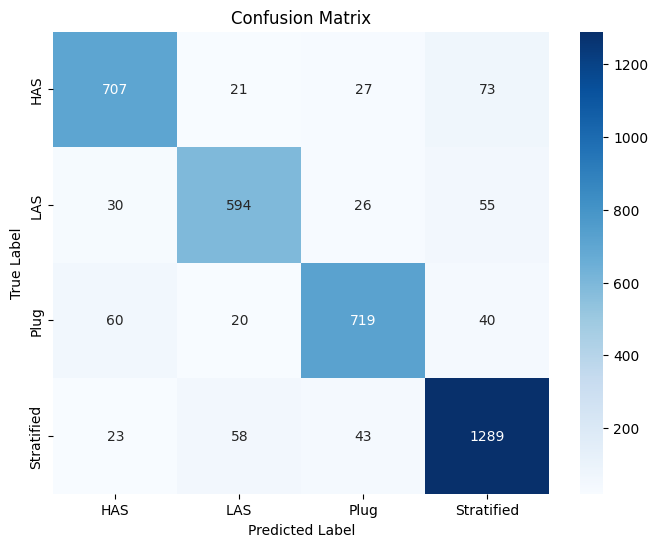

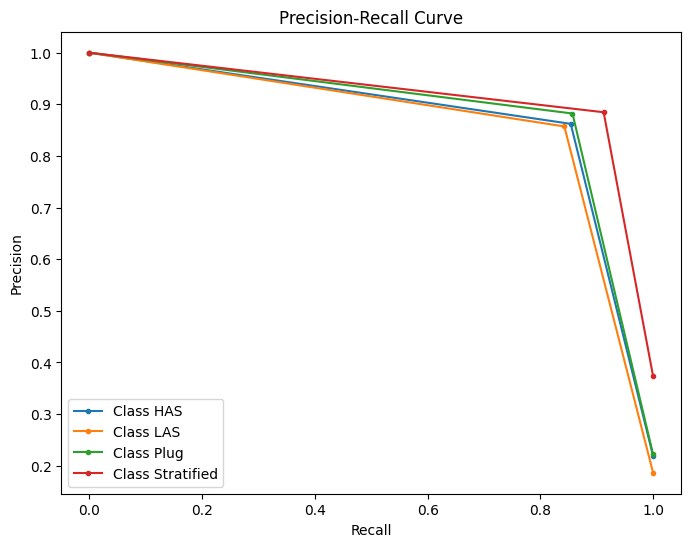

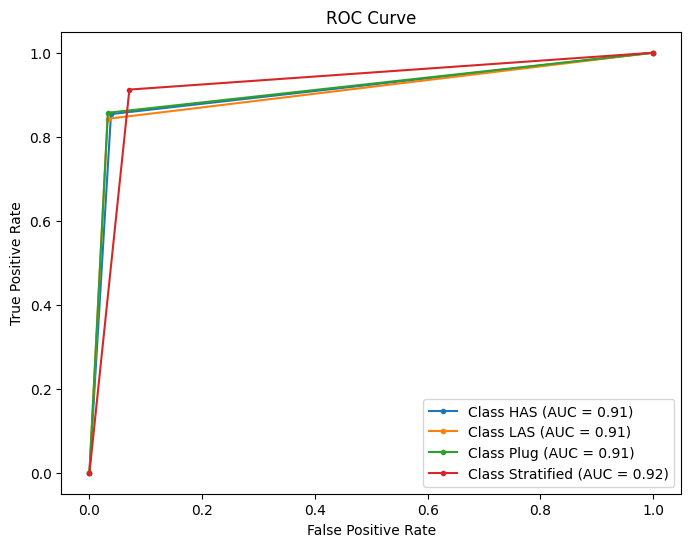

In [28]:
class_names = ['HAS','LAS','Plug','Stratified']
plot_multiclass_classification_results(true_labels, predicted_labels, predicted_probs, class_names)

In [29]:
logistic_model = model

In [31]:
torch.save(logistic_model,'../models/logistic_model.pth')